# ANALYSIS AND DESIGN OF CLOSED LOOP SYSTEMS

This notebook develops an approach and associated codes for designing closed loop systems with the controller, OLS (open loop system), filter architecture.

The first part is a discussion of other transfer functions for closed loop systems and how to incorporate them into the design.

Next, we develop the design methodology. This is based on computational optimization, and so there is a short tutorial on ``lmfit`, a python package for computational optimization.

Last, we summarize the workflow and illustrates its use. There is a brief discussion of considerations for operating range that can be incorporated into the workflow.

# Preliminaries

In [1]:
import collections
import control
import controlSBML as ctl
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te
from IPython.display import Image

# Helpers

In [2]:
TIMES = np.linspace(0, 10, 100)

In [3]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [4]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

In [5]:
# This class captures the results of a designing a closed loop system
class DesignResult(object):
    def __init__(self, grm=None, gnm=None, params=None, det=None, op_range=None):
        """
        Parameters
        ----------
        grm: control.TransferFunction
        gnm: control.TransferFunction
        params: lmfit.Parameters
        det: lmfit.MinimizerResult
        op_range: [float, float] - operating range for OLS
        
        """
        self.grm = grm
        self.gnm = gnm
        self.params = params
        self.det = det
        self.op_range = op_range
        
    def __repr__(self):
        return ""

## ``plotSys``

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "NonlinearIOSystem" in str(type(sys)):
        is_nonlinear = True
    else:
        is_nonlinear = False
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr[0]))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


# Models

## Linear

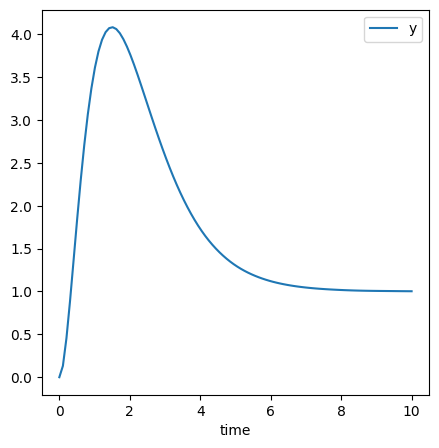

In [7]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys)

## Wolf

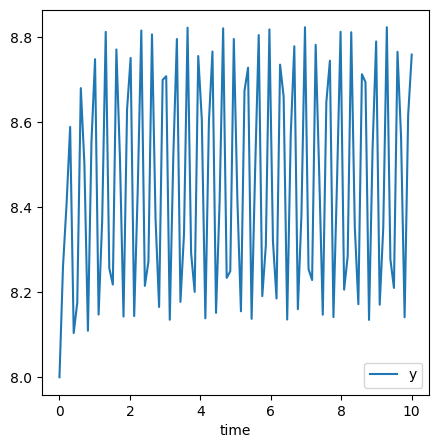

In [8]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys)

In [9]:
print(ctlsb.antimony)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Review of Transfer Functions

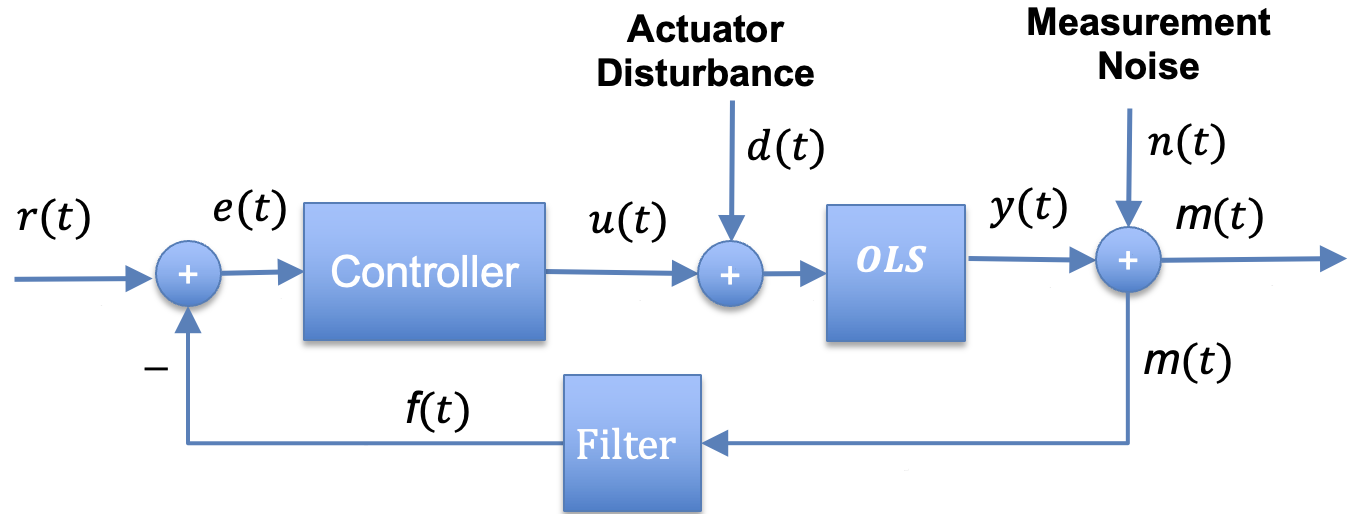

In [10]:
Image("closed_loop_system.png", width = 600, height = 300)

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
So, we need to identify which input/output relationships are of interest.

| Input  | Output | Why of interest?        | Desired DC Gain | Desired poles |
|--------|--------|-------------------------|-----------------|---------------|
| $r(t)$ | $m(t)$ | convergence to set point| 1               | very negative |
| $n(t)$ | $m(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $m(t)$ | influence of disturbance| 0               | very negative |
| $r(t)$ | $e(t)$ | convergence to set point| 0               | very negative |
| $n(t)$ | $e(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $e(t)$ | influence of disturbance| 0               | very negative |

Some other considerations:
1. Will the OLS always be within the operating region we designed for its input?
1. What are the maximum magnitudes of $d(t)$ and $n(t)$?
1. What trade-offs can we accepts?
    1. Achieved desired DC Gain but have oscillations? 
    1. Achieved desired DC Gain but have longer settling times?

# Noise Transfer Function

## Terminology

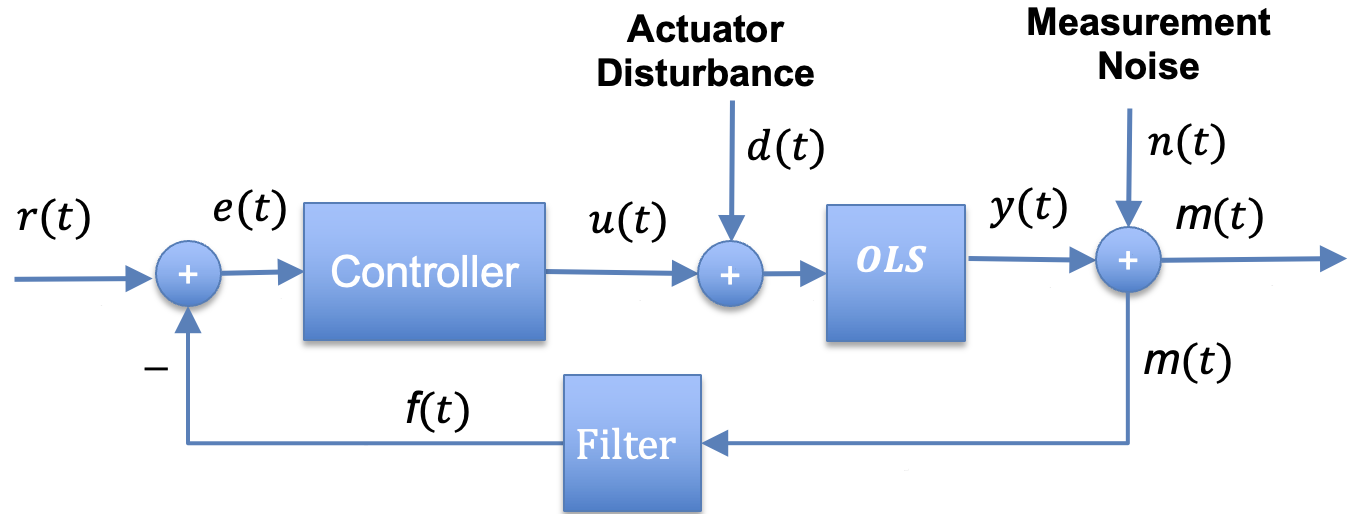

In [11]:
Image("closed_loop_system.png", width = 300, height = 150)

Define the transfer functions:
* $G_C (s)$: controller
* $G_F (s)$: filter
* $G_O (s)$: open loop system

Define the signals
* $R(s)$: reference input (set point)
* $D(s)$: disturbance
* $N(s)$: noise

## Steps for constructing a transfer function from existing system elements
1. Write equations that contain the input and output signals.
1. Construct a single equation that contains only the input and output.
1. Solve for the transfer function.

## Transfer function derivation

Find the transfer function from $n(t)$ to $m(t)$.
That is, $G_{NM} = \frac{M(s)}{N(s)}$.

This transfer function assumes
that $r(t) = 0 = d(t)$.

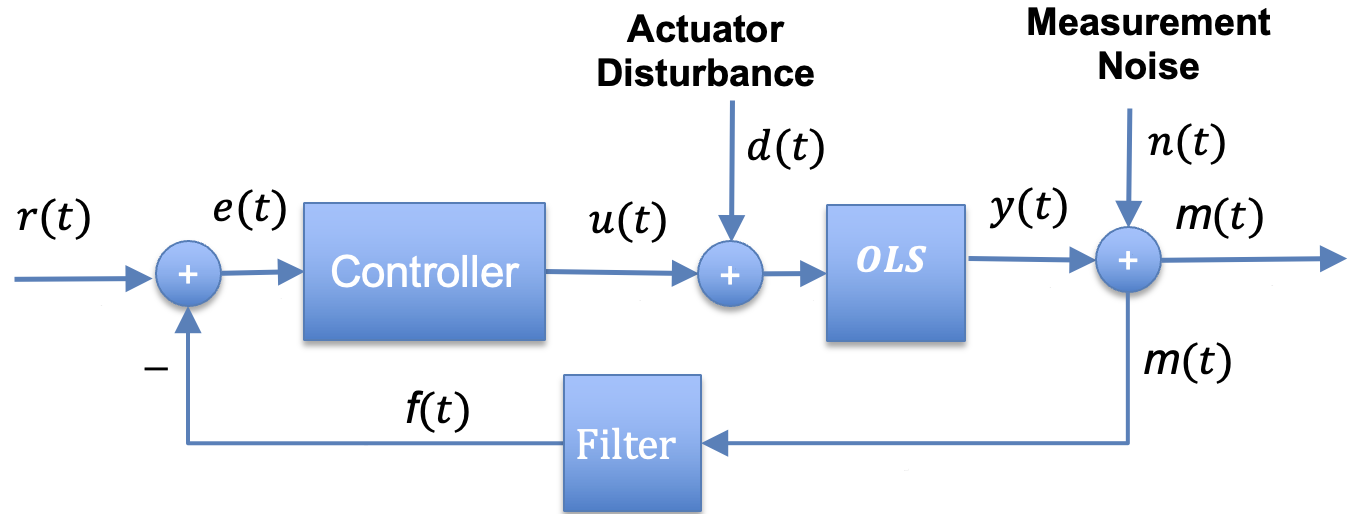

In [12]:
Image("closed_loop_system.png", width = 300, height = 150)

This simplifies to

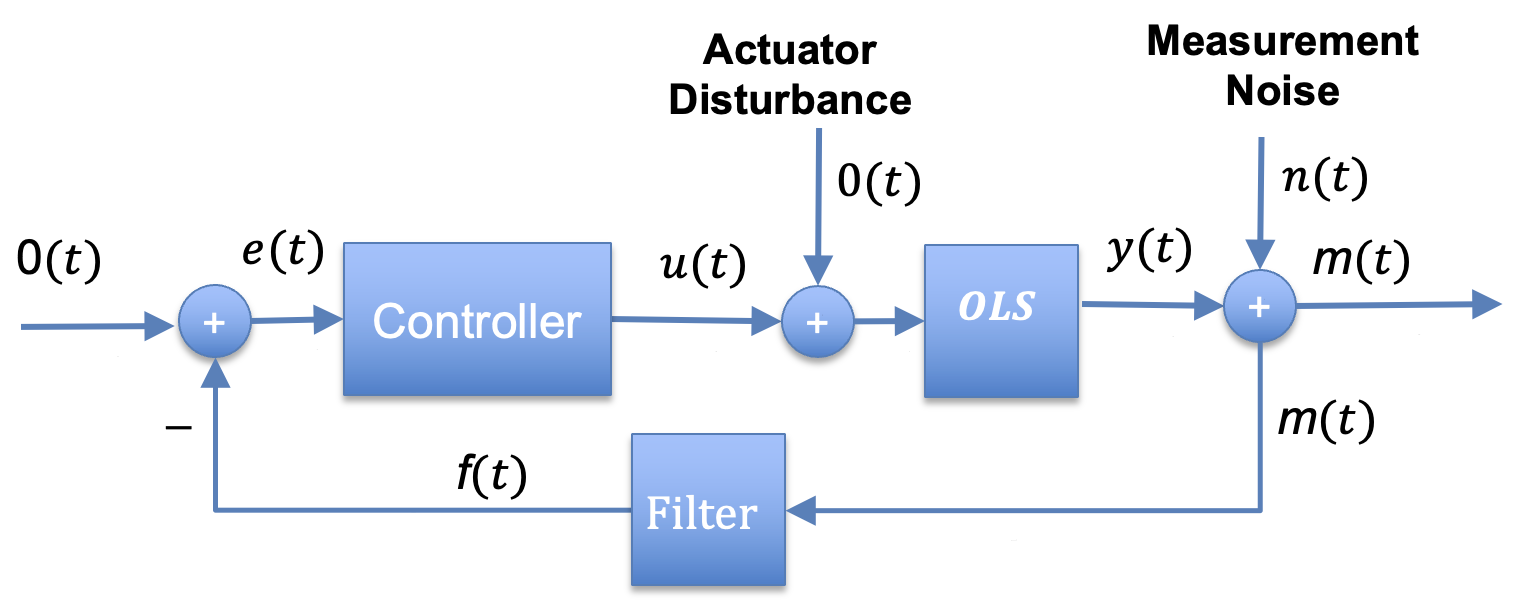

In [13]:
Image("simplified_noise_closed_loop_system.png", width = 300, height = 150)

### 1. Write the equations that contain the input and output signal

1. $M(s) = E(s) G_C (s) G_O(s) + N(s)$
1. $E(s) = - M(s) G_F(s)$

### 2. Construct a single equation that contains only the input and output

Substituting the second equation into the first:

\begin{eqnarray}
M(s) & = & E(s) G_C (s) G_O(s) + N(s) \\
M(s)&  =& - M(s) G_F(s) G_C (s) G_O(s) + N(s) \\
M(s) ( 1 + G_C (s) G_O (s) G_F (s) )&  = & N(s) \\
\end{eqnarray}

### 3. Solve for the transfer function


\begin{eqnarray}
G_{NM} (s) & = & \frac{M(s)}{N(s)} \\
& = & \frac{ 1 }{1 + G_C (s) G_O(s) G_F(s)} \\
\end{eqnarray}

## Comparison with $G_{RM}$

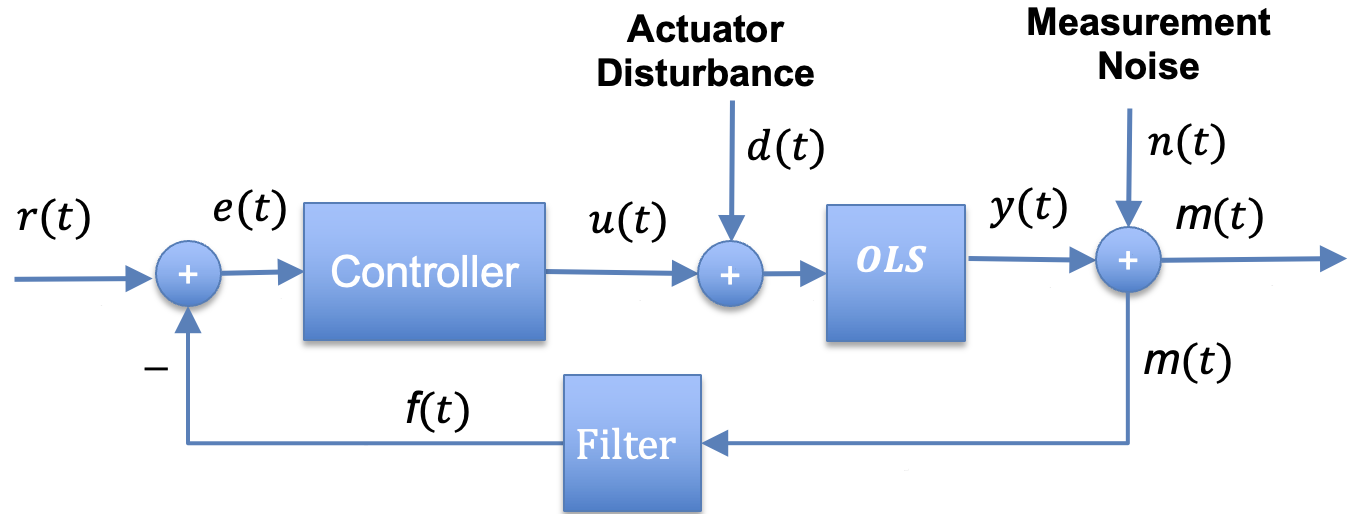

In [14]:
Image("closed_loop_system.png", width = 300, height = 150)

\begin{eqnarray}
G_{RM} (s) & = & \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)}\\
\end{eqnarray}

If $G_F(0) = 1$ and $G_{RM} (0) = 1$, then what is $G_{NM} (0)$?

These assumptions mean that
\begin{eqnarray}
G_{RM} (0)  & = & \frac{ G_C (0) G_O(0) }{1 + G_C (0) G_O(0)}\\
& = & 1 - \frac{ 1 }{1 + G_C (0) G_O(0)}\\
& = & 1 - G_{NM} (0)\\
\end{eqnarray}

So, if $G_{RM} = 1$, then $G_{RN} = 0$.

Note that $G_{RM}$ has the same poles as $G_{NM}$.

**Justification**

Let $G_x (s) = \frac{N_x(s)}{D_x (s)}$, where $N_x(s)$ and $D_x(s)$ are polynomials in $s$.
\begin{eqnarray}
G_{RM} (s)  & = & \frac{ G_C (s) G_O(s) }{1 + G_F (s) G_C (s) G_O(s)}\\
& = & \frac { N_C (s)/D_C (s) N_O(s) / D_O(s) }{1 + N_F(s)/D_F(s) N_C (s)/D_C(s) N_O(s)/D_O(s)}\\
& = & \frac {  D_F(s) N_C (s) (s) N_O(s)) }{D_F(s) D_C(s) D_O(s) + N_F(s) N_C (s) N_O(s)}\\
\end{eqnarray}

\begin{eqnarray}
G_{NM} (s)  & = & \frac{ 1 }{1 + G_F (s) G_C (s) G_O(s)}\\
& = & \frac { 1 }{1 + N_F(s)/D_F(s) N_C (s)/D_C(s) N_O(s)/D_O(s)}\\
& = & \frac { D_F(s) D_C (s) D_O(s) }{D_F(s) D_C(s) D_O(s) + N_F(s) N_C (s) N_O(s)}\\
\end{eqnarray}

# Theory-based Closed Loop Design

It suffices to consider $G_{RM}$ for control design with the objectives:
1. The dominant pole is sufficiently negative and has a sufficient small imaginary part.
1. The system is resilient to measurement noise.
1. $G_{RM}$ has a DC Gain is 1.

If we use $I$ control, then we automatically get a DC Gain of 1.

The design of the filter turns out to be more subtle.
As shown below, the initial intuition is that $k_F$ should be close to 1.
The situation turns out to be more complex.

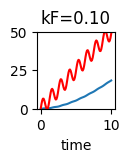

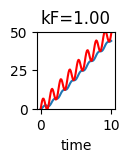

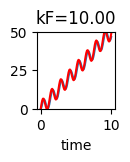

In [15]:
# Effect of the filter parameter on a linear increasing sine wave
forced_input = 5*np.sin(5*TIMES) + 5*TIMES # Linear increase
for kF in [0.1, 1, 10]:
    tf = control.TransferFunction([kF], [1, kF])
    plot_result = plotSys(tf, forced_input=forced_input, times=TIMES, figsize=(1,1), ylim=[0, 50],
           title="kF=%2.2f" % kF, is_legend=False)
    plot_result.ax.plot(TIMES, forced_input, color="red")

We see that $y(t)$ is smoother for small values of $k_F$, and $y(t)$ better approximates the signal trend (i.e., line slope) if $k_F$ is larger.

## Design problem for PI Control

Find $k_P$, $k_I$, $k_F$ such that:
1. The unit step response looks like the unit step input.
1. The effect of noise is minimized.

# Computational Optimization in Python

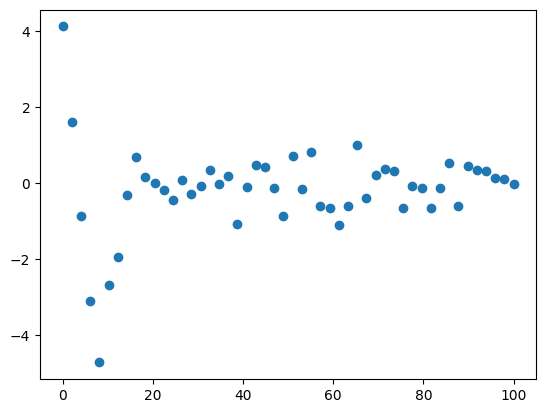

In [57]:
# Data generation
XVALUES = np.linspace(0, 100)
noise = np.random.normal(size=XVALUES.size, scale=0.5)
DATA = 7.5 * np.sin(XVALUES*0.22 + 2.5) * np.exp(-XVALUES*XVALUES*0.01) + noise
plt.scatter(XVALUES, DATA)

In [58]:
def makePredict():
    """
    Constructs a function that predicts the output from parameters and the input.
    
    Returns
    -------
    Function
      arguments: lmfit.Parameters, array-float
      returns: array-float
    """
    def predict(params, xv):
        """
    
        Parameters
        ----------
        params: lmfit.Parameters
        xv: array-float

        Returns
        -------
        array-float
        """
        amp = params['amp']
        phaseshift = params['phase']
        freq = params['frequency']
        decay = params['decay']
        predictions = amp * np.sin(xv*freq + phaseshift) * np.exp(-xv*xv*decay)
        return predictions
    return predict


def calculateResidual(params, xv, data):
    """
    Calculates the residuals for a prediction.
    
    Parameters
    ----------
    params: lmfit.Parameters
    xv: array-float (input values)
    data: array-float (observed values)
    
    Returns
    -------
    array-float (residuals)
    """
    predict = makePredict()
    predictions = predict(params, xv)
    # Can add special constraints
    if params["amp"] > 90:
        return np.repeat(1e6, len(data))
    return data - predictions


params = lmfit.Parameters()
params.add('amp', value=5)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

lmfit_result = lmfit.minimize(calculateResidual, params, args=(XVALUES, DATA))
PARAMS = lmfit_result.params
PARAMS

name,value,standard error,relative error,initial value,min,max,vary
amp,6.08024690,0.66451882,(10.93%),5,-inf,inf,True
decay,0.00646559,0.00140642,(21.75%),0.007,-inf,inf,True
phase,0.81271904,0.09203922,(11.32%),0.2,-inf,inf,True
frequency,2.82088348,0.01844856,(0.65%),3.0,-inf,inf,True


In [18]:
# True values
7.5 * np.sin(XVALUES*0.22 + 2.5) * np.exp(-XVALUES*XVALUES*0.01) + noise

array([ 4.78317357,  1.34048777, -0.95030642, -3.08936082, -3.45398019,
       -1.89503404, -1.45165939, -0.34643881, -0.0392504 ,  0.42076802,
        0.86124578, -0.07435297,  0.93572525,  0.4744571 , -0.60341842,
        1.00246298,  0.54942595,  0.06826848, -0.65448769, -0.96893427,
       -0.47376941, -0.39968458, -1.04987799, -0.93102445,  0.54818525,
       -0.0813403 , -0.47968087,  0.18028792,  0.50761834, -0.23524079,
        0.01731781,  0.75578604,  0.05424413, -0.3590588 ,  0.8584963 ,
        0.7669177 , -0.04316033, -0.43407329,  0.82285528,  0.22622479,
        0.15632438,  0.03656237, -0.54888978,  0.02934658, -0.73226065,
        0.17991748, -0.02770026, -0.16853031, -0.28541026,  0.84714073])

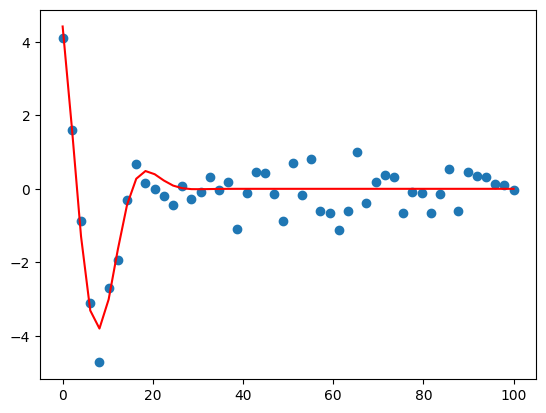

In [59]:
plt.scatter(XVALUES, DATA)
predict = makePredict()
plt.plot(XVALUES, predict(PARAMS, XVALUES), color="red")

## Cheat sheet for using ``lmfit``

1. Generate fitting data (``DATA``)
1. Write a function "factory" that creates a candidate function to fit the data
1. Write ``calculateResiduals`` that calls the function factory to calculate residuals between ``DATA`` and the candidate function
1. Construct ``lmfit.Parameters`` with initial values.
1. Run ``lmfit.minimize``

# Control Design Using Computational Optimization

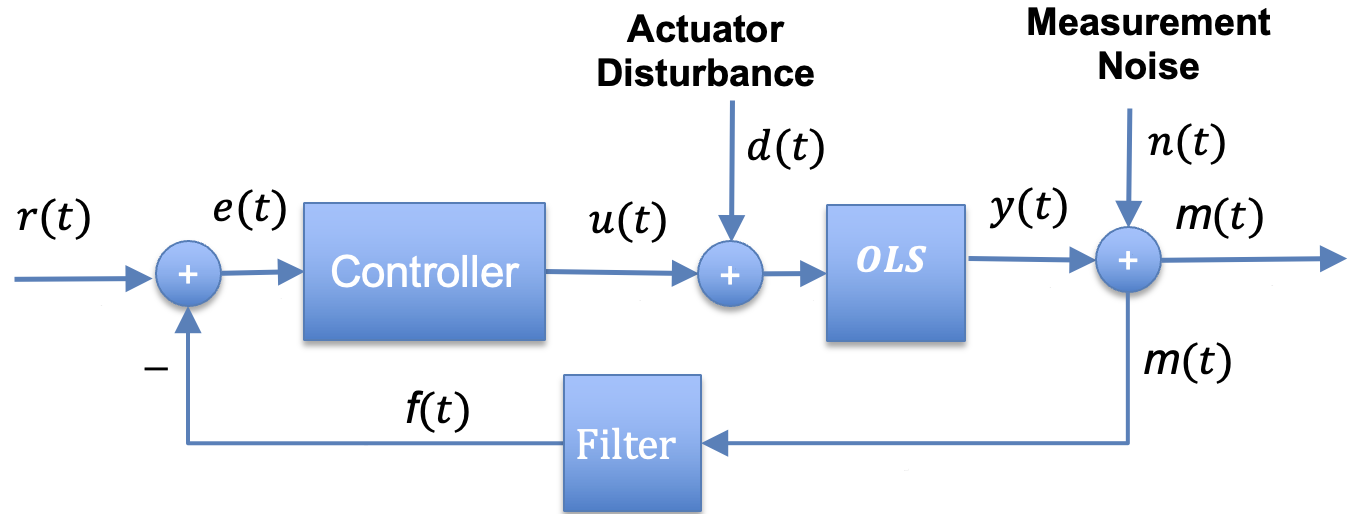

In [20]:
Image("closed_loop_system.png", width = 400, height = 200)

## Problem statement for PI Control

Find $k_P$, $k_I$, $k_F$ that minimize the sum of the following:
* unit step - step response of $G_{RM} (s)$
* 0 - response of $G_{NM} (s)$ to a sinusoidal input

This will be implemented using ``lmfit`` constrained optimization.
As a running example, we use $G_O(s) = \frac{1}{s + 2}$.

In [21]:
gO_tf = value=control.TransferFunction([1], [1, 2])
gO_tf

TransferFunction(array([1]), array([1, 2]))

## Step 1. Candidate closed loop transfer function

A candidate design for a closed loop system results in a new transfer function
for the closed loop system.
So, we need a way to construction a *transfer function*
for a new design. In software, this is called a factory. The factory inputs $k_P$, $k_I$, $k_F$.
To make it more general, we include $G_O(s)$, the open loop transfer function.
The output is the closed loop transfer function $G_{RM} (s)$.

In [60]:
# grm: G_RM
# gnm: G_NM
# gf: Filter
# gc: Controller
# go: OLS
CLTransferFunctions = collections.namedtuple("CLTransferFunctions",
      "grm gnm gc gf go")
def makeCLTransferFunctions(gO_tf, params):
    """
    Makes two closed loop transfer functions.
        G_RM (s) - transfer function from the reference input to the measurement output
        G_NM (s) - transfer function from the noise input to the measurement output
    
    Parameters
    ----------
    gO_tf: control.TransferFunction (open loop transfer function)
    params:
        kP: float
        kI: float
        kF: float (a value <= 0 indicates there is no filter
    
    Returns
    -------
    CLTransferFunctions
    """
    # Extract the parameters
    kP = params["kP"].value
    kI = params["kI"].value
    kF = params["kF"].value # a value of 0 indicates that there is no filter
    # Construct PI Controller
    gC_tf = control.TransferFunction([kP], [1]) + control.TransferFunction([kI], [1, 0])
    # Construct Filter
    if kF > 0:
        gF_tf = control.TransferFunction([kF], [1, kF])
    else:
        gF_tf = control.TransferFunction([1], [1])
    # RM Closed loop Transfer function
    gRM_tf = control.feedback(gC_tf*gO_tf, sys2=gF_tf)
    # NM Closed loop Transfer function
    gNM_tf = control.feedback(1, sys2=gC_tf*gO_tf*gF_tf)
    #
    return CLTransferFunctions(grm=gRM_tf, gnm=gNM_tf, gc=gC_tf, gf=gF_tf, go=gO_tf)
#
is_plot = False
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kF", value=1)
cltf = makeCLTransferFunctions(gO_tf, params)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
plot_response = plotSys(cltf.grm, is_plot=is_plot)
plot_response = plotSys(cltf.gnm, is_plot=is_plot)
print("OK!")

OK!


## Step 2. Calculate residuals

The key challenge here is what residuals are we computing. At first glance, there is no
observational data to compare against.
However, on second thought, there are two sets of observational data.
The first is an ideal unit step response, which is just a unit step.
The second is an ideal noise response, which is a constant at zero.
The first is the ideal response for $G_{RM} (s)$ to a step in $R(s)$.
The second is the ideal response for $G_{NM} (s)$ to noise input.

In [61]:
def calculateDesignResiduals(params, amp=0.1):
    """
    Calculates the sum of the residuals to a step response and the residuals for sinusoidal noise.
    
    Parameters
    ----------
    params: lmfit.Parameters
    amp: float (amplitude of sinusoidal signal)
    
    Returns
    -------
    array-float
    """
    cltf = makeCLTransferFunctions(gO_tf, params)
    gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
    times = np.linspace(0, 10, 100)
    # Calculate residuals for a step response
    _, yv_est = control.forced_response(gRM_tf, T=times, U=1)
    yv_ideal = np.repeat(1, len(times)) # Unit step
    step_residuals = yv_ideal - yv_est
    # Calculate residuals for a sinusoidal noise input
    inputs = amp*np.sin(5*times) # Sinusoid input
    times, yv_est = control.forced_response(gNM_tf, T=times, U=inputs)
    yv_ideal = np.repeat(0, len(times))
    sinusoid_residuals = yv_ideal - yv_est
    #
    return step_residuals + sinusoid_residuals

# Tests
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=0)
params.add("kF", value=0)
residuals = calculateDesignResiduals(params)
assert(np.sum(residuals) > 0)
print("OK!")

OK!


## Step 3. Do the optimization

In [62]:
params = lmfit.Parameters()
params.add("kP", value=1, min=0, max=1e2)
params.add("kI", value=1, min=0, max=1e2)
params.add("kF", value=1, min=0, max=1e2)

out = lmfit.minimize(calculateDesignResiduals, params)
out.params

name,value,standard error,relative error,initial value,min,max,vary
kP,99.9999905,228.367554,(228.37%),1,0.00000000,100.000000,True
kI,99.9999141,304.296434,(304.30%),1,0.00000000,100.000000,True
kF,57.4649471,248.478335,(432.40%),1,0.00000000,100.000000,True


In [63]:
cltf = makeCLTransferFunctions(gO_tf, out.params)
cltf.grm.poles()

array([-29.23738732+70.34699091j, -29.23738732-70.34699091j,
        -0.99017249 +0.j        ])

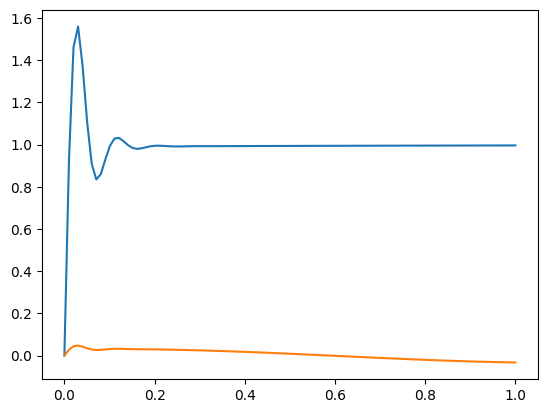

In [64]:

times = np.linspace(0,1, 100)
_, yv = control.forced_response(cltf.grm, T=times, U=1)
plt.plot(times, yv)
_, yv = control.forced_response(cltf.gnm, T=times, U=np.sin(3*times))
plt.plot(times, yv)

# Encapsulating the Workflow

Our ability to explore designs is much improved by wrapping the foregoing 3 steps into
a single function.
We leave ``makeCLTransferFunction`` as a separate function.
We create ``designCLosedLoop`` that takes as input the open loop transfer function
and several optional arguments that assist with design explorations.

In [36]:
def designClosedLoop(open_loop_tf, is_filter=True, amp=1, kmax=1e4):
    """
    Finds parameters for the closed loop system that eliminate noise and have a good step response.
    
    Paramters
    ---------
    open_loop_tf: control.TransferFunction (OLS transfer function)
    is_filter: bool (include the filter)
    amp: 0 <=float  (amplitude of the sine wave used to evaluate noise response)
    kmax: float (maximum value of a constant)
    
    Returns
    -------
    DesignResult
    """
    times = np.linspace(0, 10, 100)
    step_inputs = np.repeat(1, len(times))
    ideal_step_outputs = step_inputs
    noise_inputs = amp*np.sin(5*times) # Sinusoid input
    ideal_noise_outputs = np.repeat(0, len(times))
    def calculateDesignResiduals(params):
        """
        Calculates the residuals with an ideal step response.

        Parameters
        ----------
        params: lmfit.Parameters

        Returns
        -------
        array-float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params)
        gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
        # Calculate residuals for a step response
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        step_residuals = ideal_step_outputs - step_est
        # Calculate residuals for a sinusoidal noise input
        _, sinusoid_est = control.forced_response(gNM_tf, T=times, U=noise_inputs)
        sinusoid_residuals = ideal_noise_outputs - sinusoid_est
        #
        return step_residuals + sinusoid_residuals
    #
    def calculateOperatingRange(params):
        """
        Calculates the operating range for the closed loop system designed with parameters
        
        Parameters
        ----------
        params: lmfit.Parameters
        
        Returns
        -------
        float, float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params)
        gRM_tf, gNM_tf, gC_tf = (cltf.grm, cltf.gnm, cltf.gc)
        #######
        # Step
        #######
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        # Calculate input to controller
        ctl_inputs = step_inputs - step_est
        # Calculate controller output
        _, step_outputs = control.forced_response(gC_tf, T=times, U=ctl_inputs)
        #######
        # Noise
        #######
        # Calculate input to controller
        _, noise_est = control.forced_response(gRM_tf, T=times, U=noise_inputs)
        # Calculate input to controller
        ctl_inputs = noise_inputs - noise_est
        _, noise_outputs = control.forced_response(gC_tf, T=times, U=step_inputs)
        # Calculate operating range, the extreme values of inputs to the open loop system
        ols_inputs = np.append(step_outputs, noise_outputs)
        op_range = np.min(ols_inputs), np.max(ols_inputs)
        return op_range
    # 
    params = lmfit.Parameters()
    params.add("kP", value=1, min=0, max=kmax)
    params.add("kI", value=1, min=0, max=kmax)
    params.add("kF", value=1, min=0, max=kmax)
    minimizer_result = lmfit.minimize(calculateDesignResiduals, params)
    new_params = minimizer_result.params
    #
    cltf = makeCLTransferFunctions(gO_tf, new_params)
    gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
    op_range = calculateOperatingRange(new_params)
    design_result = DesignResult(grm=gRM_tf, gnm=gNM_tf, params=new_params, det=minimizer_result,
                                op_range=op_range)
    return design_result

# Tests
design_result = designClosedLoop(gO_tf, kmax=1e6, amp=10)
assert(isinstance(design_result.grm, control.TransferFunction))
assert(design_result.op_range[0] <= design_result.op_range[1])
print("OK!")

OK!


In [37]:
gO_tf

TransferFunction(array([1]), array([1, 2]))

In [38]:
design_result = designClosedLoop(gO_tf, kmax=1e2, amp=10)
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,100.0000000,3.27307728,(3.27%),1,0.00000000,100.000000,True
kI,99.9999999,22.2556152,(22.26%),1,0.00000000,100.000000,True
kF,11.6908207,1.48491055,(12.70%),1,0.00000000,100.000000,True


OK!


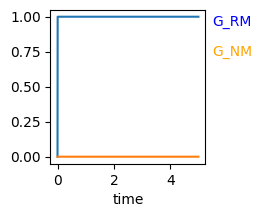

In [45]:
# Plots of the transfer functions
def plotDesignResult(design_result, ax=None, end_time=50, title="", is_plot=True, **kwargs):
    """
    Plots a DesignResult.
    
    Parameters
    ----------
    design_result: DesignResult
    ax: Matplotlib.Axes
    end_time: float
    is_plot: bool
    kwargs: dict (other plotting options)
    """
    if ax is None:
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (3, 3)
        _, ax = plt.subplots(1, figsize=figsize)
    times = np.linspace(0, end_time, 2000)
    plot_result1 = plotSys(design_result.grm, forced_input=1, times=times, ax=ax,
                         is_legend=False)
    plot_result2 = plotSys(design_result.gnm, forced_input=np.sin(5*times), times=times, 
            is_legend=False, ax=ax)
    if "ylim" in kwargs.keys():
        ylim = kwargs["ylim"]
    else:
        ylim = ax.set_ylim()
    xpos = end_time*1.1
    yspan = ylim[1] - ylim[0]
    ypos1 = ylim[1] - 0.1*yspan
    ypos2 = ypos1 - 0.2*yspan
    ax.text(xpos, ypos1, "G_RM", c="blue")
    ax.text(xpos, ypos2, "G_NM", c="orange")
    ax.set_ylim(ylim)
    ax.set_title(title)
    if not is_plot:
        plt.close()
 
# Tests
plotDesignResult(design_result, kmax=1, figsize= (2,2), is_plot=True, end_time=5)
print("OK!")

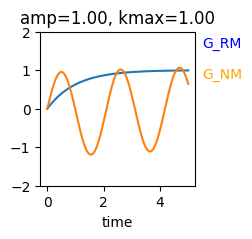

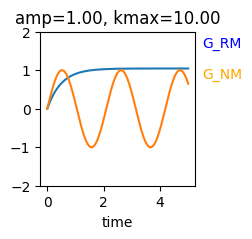

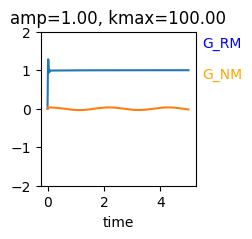

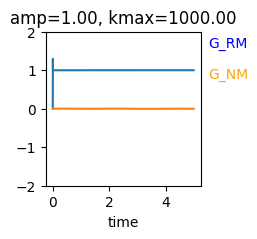

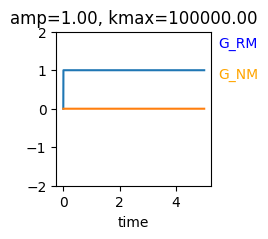

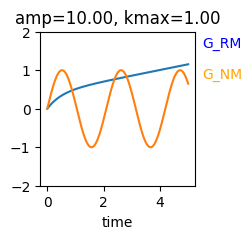

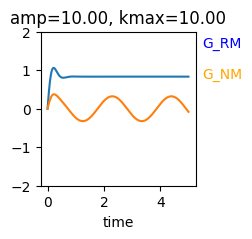

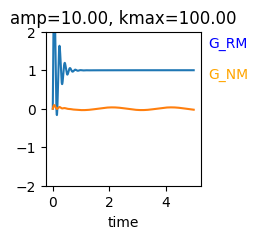

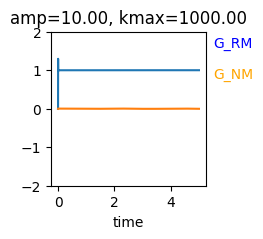

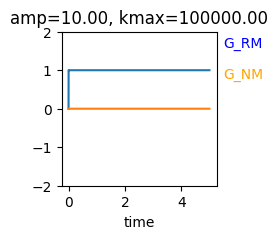

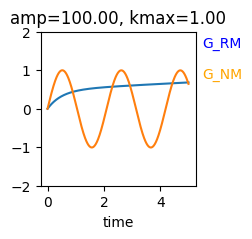

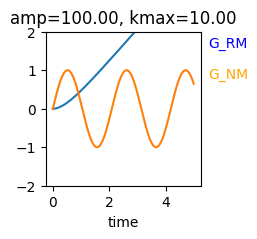

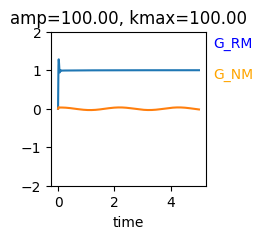

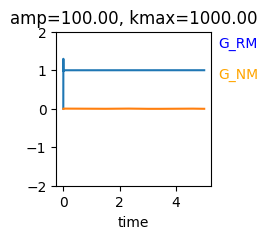

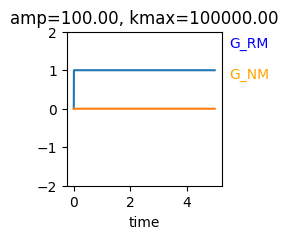

In [42]:
kmaxs = [1, 10, 1e2, 1e3, 1e5]
amps = [1, 10, 100]
for amp in amps:
    for kmax in kmaxs:
        design_result = designClosedLoop(gO_tf, kmax=kmax, amp=amp)
        title = "amp=%2.2f, kmax=%2.2f" % (amp, kmax)
        plotDesignResult(design_result, figsize=(2,2), ylim=[-2, 2], title=title, kmax=kmax, end_time=5)

In [52]:
design_result = designClosedLoop(gO_tf, kmax=100, amp=10)
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,100.0000000,3.27307728,(3.27%),1,0.00000000,100.000000,True
kI,99.9999999,22.2556152,(22.26%),1,0.00000000,100.000000,True
kF,11.6908207,1.48491055,(12.70%),1,0.00000000,100.000000,True


In [53]:
design_result.grm


TransferFunction(array([ 100.        , 1269.08206965, 1169.08206877]), array([1.00000000e+00, 1.36908207e+01, 1.19246371e+03, 1.16908207e+03]))

In [54]:
design_result.grm.poles()

array([-6.34998619+33.75733461j, -6.34998619-33.75733461j,
       -0.99084831 +0.j        ])

# Checking the Operating Range

We modeled the open loop system for a particular operating range.
To have confidence in our design, we want to make sure that the closed loop system
presents inputs to the OLS that are within the operating range that we modeled.

In [55]:
design_result.op_range # Lower and upper limits of the OLS operating range for the design

(-11.813372154592347, 1099.999999173365)